# ECE-GY 7123 Deep Learning Fall 2025 Final Project
#### Hao Wu hw3655@nyu.edu

This project addresses
the Multi-Label Text Classification problem,
where a single comment may belong to multiple
toxicity categories simultaneously. We aim to
implement and fine-tune deep transformer-based
architectures to effectively capture the semantic
context of toxic language and handle class
imbalance in a real-world dataset.

## 1. Setup

Install all needed dependencies.

In [65]:
!pip install -q transformers datasets accelerate scikit-learn pandas

In [66]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Load Dataset
We use the **Jigsaw Toxic Comment Classification** dataset from Kaggle, which contains approximately 159,000 Wikipedia talk page comments. Each comment can have multiple toxicity labels simultaneously:
- `toxic`: General toxicity
- `severe_toxic`: Extremely toxic content
- `obscene`: Obscene language
- `threat`: Threatening content
- `insult`: Insulting language
- `identity_hate`: Hate speech targeting identity groups

This is a **multi-label classification** problem where a single comment may belong to multiple categories.

Load `jigsaw-toxic-comment-classification-challenge` dataset from HuggingFace.

In [67]:
from datasets import load_dataset

ds = load_dataset("thesofakillers/jigsaw-toxic-comment-classification-challenge")
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
        num_rows: 159571
    })
    test: Dataset({
        features: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'],
        num_rows: 306328
    })
})

In [68]:
import matplotlib.pyplot as plt

label_cols = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
text_col = "comment_text"

df_train = ds["train"].to_pandas()
df_train[text_col] = df_train[text_col].fillna("").astype(str)

df_train[label_cols] = df_train[label_cols].fillna(0).astype(int)
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## 3. Train/Validation Split


We convert the six binary label columns into a single `labels` vector (length = 6) for multi-label training.
Missing comment text is replaced with an empty string.

In [69]:
def add_labels(example):
    example[text_col] = example[text_col] or ""
    example["labels"] = [float(example[c]) for c in label_cols]
    return example

ds["train"] = ds["train"].map(add_labels)

Map:   0%|          | 0/159571 [00:00<?, ? examples/s]

The original dataset does not provide a validation split, so we create a validation set from the training split.

In [70]:
split = ds["train"].train_test_split(test_size=0.1, seed=42)
ds = {
    "train": split["train"],
    "validation": split["test"]
}

## 4. Tokenization

We tokenize the input text using the DistilBERT tokenizer. We truncate long comments to a fixed maximum length for efficiency.

In [71]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_fn(batch):
    return tokenizer(batch[text_col], truncation=True, max_length=256)

ds["train"] = ds["train"].map(tokenize_fn, batched=True)
ds["validation"] = ds["validation"].map(tokenize_fn, batched=True)

cols_to_keep = ["input_ids", "attention_mask", "labels"]
ds["train"].set_format(type="torch", columns=cols_to_keep)
ds["validation"].set_format(type="torch", columns=cols_to_keep)


Map:   0%|          | 0/143613 [00:00<?, ? examples/s]

Map:   0%|          | 0/15958 [00:00<?, ? examples/s]

## 5. Class Imbalance Analysis
We compute the number of positive and negative samples for each label in the training set.

In [72]:
df_train = ds["train"].to_pandas()

pos_counts = df_train[label_cols].sum().values
neg_counts = len(df_train) - pos_counts

print("Positive counts:", dict(zip(label_cols, pos_counts)))
print("Negative counts:", dict(zip(label_cols, neg_counts)))

Positive counts: {'toxic': np.int64(13801), 'severe_toxic': np.int64(1450), 'obscene': np.int64(7613), 'threat': np.int64(442), 'insult': np.int64(7113), 'identity_hate': np.int64(1276)}
Negative counts: {'toxic': np.int64(129812), 'severe_toxic': np.int64(142163), 'obscene': np.int64(136000), 'threat': np.int64(143171), 'insult': np.int64(136500), 'identity_hate': np.int64(142337)}


As we can see, the dataset is highly imbalanced.

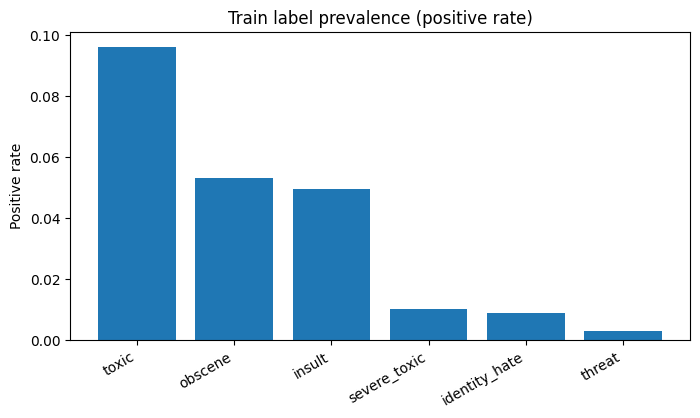

Positive counts:


,pos_count
toxic,13801
obscene,7613
insult,7113
severe_toxic,1450
identity_hate,1276
threat,442


In [73]:
pos_rate = df_train[label_cols].mean().sort_values(ascending=False)
pos_cnt = df_train[label_cols].sum().loc[pos_rate.index]

plt.figure(figsize=(8,4))
plt.bar(pos_rate.index, pos_rate.values)
plt.xticks(rotation=30, ha="right")
plt.ylabel("Positive rate")
plt.title("Train label prevalence (positive rate)")
plt.show()

print("Positive counts:")
display(pos_cnt.to_frame("pos_count"))

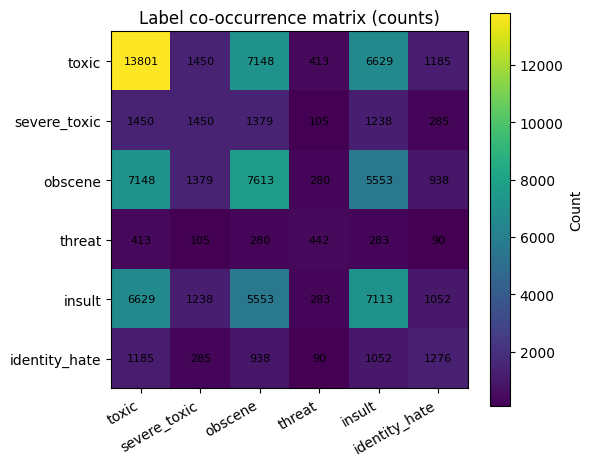

In [74]:
co = (df_train[label_cols].T @ df_train[label_cols]).astype(int)  # 6x6
co = co.loc[label_cols, label_cols]

plt.figure(figsize=(6,5))
plt.imshow(co.values)
plt.colorbar(label="Count")
plt.xticks(range(len(label_cols)), label_cols, rotation=30, ha="right")
plt.yticks(range(len(label_cols)), label_cols)
plt.title("Label co-occurrence matrix (counts)")
for i in range(len(label_cols)):
    for j in range(len(label_cols)):
        plt.text(j, i, str(co.values[i, j]), ha="center", va="center", fontsize=8)
plt.tight_layout()
plt.show()


## 6. Class Weights for Imbalanced Learning
We compute class-balanced weights based on the effective number of samples.

In [75]:
import numpy as np

raw_pos_weights = neg_counts / pos_counts
print("Raw pos_weights:", dict(zip(label_cols, raw_pos_weights.round(2))))

def compute_effective_weights(class_counts, beta=0.99):
    effective_num = 1.0 - np.power(beta, class_counts)
    weights = (1.0 - beta) / effective_num
    weights = weights / weights.min()
    return weights

effective_weights = compute_effective_weights(pos_counts, beta=0.99)
print("Effective weights:", dict(zip(label_cols, effective_weights.round(2))))

class_weights = torch.tensor(effective_weights, dtype=torch.float)

Raw pos_weights: {'toxic': np.float64(9.41), 'severe_toxic': np.float64(98.04), 'obscene': np.float64(17.86), 'threat': np.float64(323.92), 'insult': np.float64(19.19), 'identity_hate': np.float64(111.55)}
Effective weights: {'toxic': np.float64(1.0), 'severe_toxic': np.float64(1.0), 'obscene': np.float64(1.0), 'threat': np.float64(1.01), 'insult': np.float64(1.0), 'identity_hate': np.float64(1.0)}


## 7. Model
We fine-tune a pretrained DistilBERT model for multi-label classification by setting `problem_type="multi_label_classification"`.

In [76]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=6,
    problem_type="multi_label_classification"
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 8. Focal Loss for Multi-Label Imbalance
We implement a focal loss to emphasize hard examples. We additionally incorporate class weights and label smoothing.
This helps improve performance on rare labels such as `threat` and `severe_toxic`.

In [77]:
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, pos_weight=None, label_smoothing=0.0):
        super().__init__()
        self.gamma = gamma
        self.pos_weight = pos_weight
        self.label_smoothing = label_smoothing

    def forward(self, logits, targets):
        if self.label_smoothing > 0:
            targets = targets * (1 - self.label_smoothing) + 0.5 * self.label_smoothing

        bce_loss = nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction='none')

        probs = torch.sigmoid(logits)
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma

        if self.pos_weight is not None:
            weight = self.pos_weight * targets + (1 - targets)
            focal_weight = focal_weight * weight

        loss = focal_weight * bce_loss
        return loss.mean()

## 9. Custom Trainer
We override the default Trainer loss computation to use our focal loss during training.
We ensure that class weights are moved to the correct device.

In [78]:
from transformers import Trainer

class FocalLossTrainer(Trainer):
    def __init__(self, *args, focal_gamma=2.0, pos_weight=None, label_smoothing=0.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.focal_loss = FocalLoss(
            gamma=focal_gamma,
            pos_weight=pos_weight,
            label_smoothing=label_smoothing
        )

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        if self.focal_loss.pos_weight is not None:
            self.focal_loss.pos_weight = self.focal_loss.pos_weight.to(logits.device)

        loss = self.focal_loss(logits, labels)
        inputs["labels"] = labels

        return (loss, outputs) if return_outputs else loss

## 10. Evaluation Metrics and Per-Label Threshold Tuning
We compute F1-micro, F1-macro, and macro ROC-AUC.
Because a fixed threshold of 0.5 is not always optimal for imbalanced multi-label problems, we loop through each threshold to find the one that maximizes F1 for each label.


In [79]:
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve

def compute_metrics_opt(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))

    optimal_thresholds = []
    for i in range(labels.shape[1]):
        precision, recall, thresholds = precision_recall_curve(labels[:, i], probs[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_idx = np.argmax(f1_scores)
        best_thresh = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
        optimal_thresholds.append(best_thresh)

    preds = np.column_stack([
        (probs[:, i] >= optimal_thresholds[i]).astype(int)
        for i in range(len(optimal_thresholds))
    ])

    metrics = {
        "f1_micro": f1_score(labels, preds, average="micro", zero_division=0),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "auc_macro": roc_auc_score(labels, probs, average="macro"),
    }

    for i, label in enumerate(label_cols):
        metrics[f"f1_{label}"] = f1_score(
            labels[:, i], preds[:, i], zero_division=0
        )
        metrics[f"thresh_{label}"] = optimal_thresholds[i]

    return metrics

## 11. Training Configuration
We train using a standard fine-tuning setup. We evaluate periodically and apply early stopping.
We select the best checkpoint based on validation F1-macro after threshold tuning.

In [80]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

args = TrainingArguments(
    output_dir="./jigsaw_distilbert_focal",
    eval_strategy="steps",
    eval_steps=1000,
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=2,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_steps=100,
    fp16=True,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
)

trainer = FocalLossTrainer(
    model=model,
    args=args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics_opt,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    focal_gamma=2.0,
    pos_weight=class_weights,
    label_smoothing=0.05,
)

/tmp/ipython-input-325510810.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FocalLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [81]:
trainer.train()
trainer_results = trainer.evaluate()

Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Auc Macro,F1 Toxic,Thresh Toxic,F1 Severe Toxic,Thresh Severe Toxic,F1 Obscene,Thresh Obscene,F1 Threat,Thresh Threat,F1 Insult,Thresh Insult,F1 Identity Hate,Thresh Identity Hate
1000,0.017500,0.016467,0.720956,0.535918,0.953453,0.786532,0.278944,0.489796,0.362518,0.816085,0.367043,0.148760,0.275617,0.707317,0.372277,0.267016,0.309754
2000,0.014200,0.012817,0.764613,0.583356,0.981917,0.815501,0.537072,0.509434,0.506439,0.830389,0.488352,0.189189,0.303629,0.747731,0.461805,0.407895,0.353540
3000,0.012800,0.011828,0.772280,0.637141,0.986082,0.810961,0.503197,0.491694,0.413714,0.827506,0.538619,0.437500,0.294519,0.757015,0.423458,0.498168,0.336331
4000,0.012300,0.012573,0.772042,0.641106,0.988471,0.821393,0.553475,0.476190,0.409398,0.832658,0.573977,0.422535,0.443721,0.751486,0.539954,0.542373,0.433262
5000,0.012100,0.011269,0.784561,0.645985,0.988348,0.821540,0.508247,0.525597,0.444926,0.838671,0.584212,0.405797,0.264738,0.766378,0.459197,0.517928,0.456864
6000,0.009000,0.011873,0.785522,0.658405,0.989610,0.831321,0.577495,0.486339,0.526769,0.844186,0.525141,0.457143,0.507812,0.763872,0.512235,0.567568,0.435001
7000,0.009700,0.010910,0.793059,0.675359,0.989853,0.831750,0.520481,0.527221,0.507205,0.839721,0.559170,0.491803,0.473779,0.774786,0.465023,0.586873,0.487079
8000,0.010400,0.011287,0.793388,0.678212,0.989428,0.828443,0.392861,0.537764,0.343782,0.847017,0.446163,0.486486,0.338405,0.770341,0.436322,0.599222,0.437703
9000,0.008300,0.010544,0.793633,0.673019,0.990066,0.831742,0.445198,0.543956,0.419172,0.834212,0.489831,0.450000,0.480022,0.782283,0.429549,0.595918,0.483618
10000,0.009100,0.010427,0.794936,0.671766,0.990579,0.838645,0.515521,0.518519,0.404272,0.838137,0.469840,0.481928,0.399343,0.776791,0.458743,0.576577,0.532364


In [82]:
save_path = "/content/drive/MyDrive/DL-Fall-25/final_model_focal_loss"

trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)
print(f"Model checkpoint and tokenizer saved to: {save_path}")

Model checkpoint and tokenizer saved to: /content/drive/MyDrive/DL-Fall-25/final_model_focal_loss


## 12. Baseline Model

Here we train a baseline model that does not do class weighting, focal loss and threshold optimization for later comparison purpose.

In [83]:
from transformers import AutoModelForSequenceClassification

baseline_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=6,
    problem_type="multi_label_classification"
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [84]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))
    preds = (probs >= 0.5).astype(int)

    metrics = {
        "f1_micro": f1_score(labels, preds, average="micro", zero_division=0),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "auc_macro": roc_auc_score(labels, probs, average="macro"),
    }

    for i, label in enumerate(label_cols):
        metrics[f"f1_{label}"] = f1_score(
            labels[:, i], preds[:, i], zero_division=0
        )

    return metrics

In [85]:
from transformers import TrainingArguments
from transformers import Trainer, DataCollatorWithPadding, EarlyStoppingCallback

baseline_args = TrainingArguments(
    output_dir="./baseline_distilbert",
    eval_strategy="steps",
    eval_steps=1000,
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=2,

    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,

    weight_decay=0.01,
    warmup_ratio=0.1,

    logging_steps=100,
    fp16=True,
    report_to="none",

    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

baseline_trainer = Trainer(
    model=baseline_model,
    args=baseline_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

baseline_trainer.train()
baseline_results = baseline_trainer.evaluate()

/tmp/ipython-input-2865446258.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  baseline_trainer = Trainer(


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Auc Macro,F1 Toxic,F1 Severe Toxic,F1 Obscene,F1 Threat,F1 Insult,F1 Identity Hate
1000,0.064300,0.056318,0.702767,0.369377,0.930493,0.749903,0.000000,0.787565,0.000000,0.678796,0.000000
2000,0.050100,0.045384,0.751042,0.466952,0.979264,0.813835,0.470948,0.814861,0.000000,0.702069,0.000000
3000,0.046200,0.042733,0.757093,0.415747,0.984043,0.804651,0.127168,0.828571,0.000000,0.734092,0.000000
4000,0.042700,0.045011,0.766851,0.509982,0.987541,0.810625,0.251366,0.814696,0.139535,0.751275,0.292398
5000,0.043200,0.042433,0.769670,0.486536,0.987328,0.820596,0.116959,0.809943,0.000000,0.753807,0.417910
6000,0.031200,0.040822,0.783070,0.637808,0.989099,0.827160,0.512953,0.834862,0.405797,0.762985,0.483092
7000,0.036100,0.039339,0.786058,0.636752,0.988921,0.830201,0.501319,0.835738,0.320000,0.760673,0.572581
8000,0.038900,0.038360,0.764993,0.540618,0.988804,0.800602,0.000000,0.826911,0.311111,0.752089,0.552995


## 13. Result Visualization

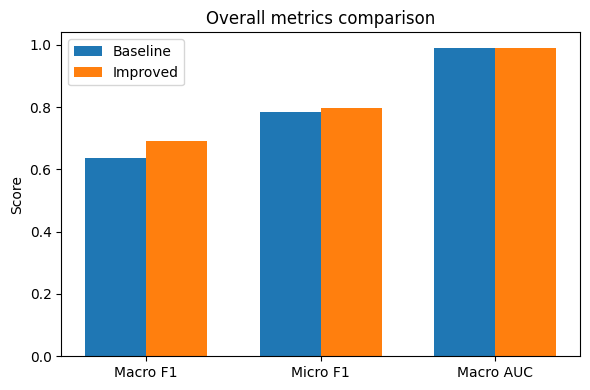

In [86]:
overall_keys = ["eval_f1_macro", "eval_f1_micro", "eval_auc_macro"]
overall_names = ["Macro F1", "Micro F1", "Macro AUC"]

baseline_vals = [baseline_results.get(k, np.nan) for k in overall_keys]
improved_vals = [trainer_results.get(k, np.nan) for k in overall_keys]

x = np.arange(len(overall_keys))
w = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - w/2, baseline_vals, w, label="Baseline")
plt.bar(x + w/2, improved_vals, w, label="Improved")
plt.xticks(x, overall_names)
plt.ylabel("Score")
plt.title("Overall metrics comparison")
plt.legend()
plt.tight_layout()
plt.show()

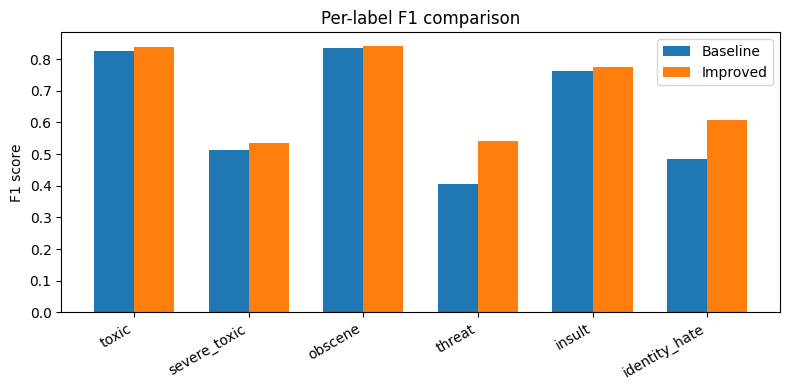

In [87]:
label_cols = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

baseline_f1 = [baseline_results.get(f"eval_f1_{l}", np.nan) for l in label_cols]
improved_f1 = [trainer_results.get(f"eval_f1_{l}", np.nan) for l in label_cols]

x = np.arange(len(label_cols))
w = 0.35

plt.figure(figsize=(8,4))
plt.bar(x - w/2, baseline_f1, w, label="Baseline")
plt.bar(x + w/2, improved_f1, w, label="Improved")
plt.xticks(x, label_cols, rotation=30, ha="right")
plt.ylabel("F1 score")
plt.title("Per-label F1 comparison")
plt.legend()
plt.tight_layout()
plt.show()


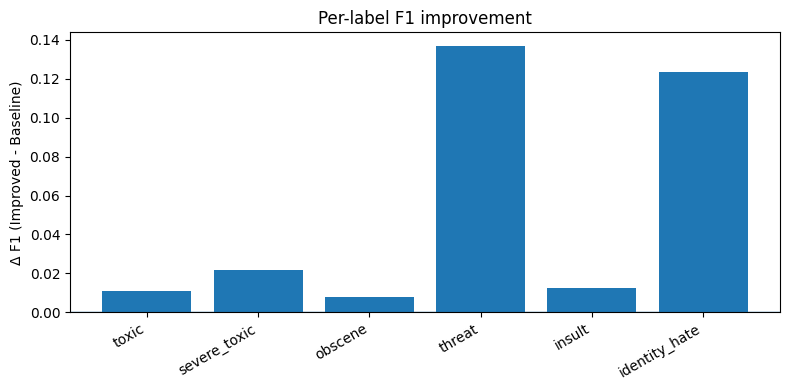

In [88]:
delta = np.array(improved_f1) - np.array(baseline_f1)

plt.figure(figsize=(8,4))
plt.bar(np.arange(len(label_cols)), delta)
plt.xticks(np.arange(len(label_cols)), label_cols, rotation=30, ha="right")
plt.axhline(0, linewidth=1)
plt.ylabel("Δ F1 (Improved - Baseline)")
plt.title("Per-label F1 improvement")
plt.tight_layout()
plt.show()
